In [8]:
# Problem Set 10
# Name: Darya Redka
# Collaborators:
# Time:

#Code shared across examples
import pylab, random, string, copy, math

class Point(object):
    def __init__(self, name, originalAttrs, normalizedAttrs = None):
        """normalizedAttrs and originalAttrs are both arrays"""
        self.name = name
        self.unNormalized = originalAttrs
        self.attrs = normalizedAttrs
    def dimensionality(self):
        return len(self.attrs)
    def getAttrs(self):
        return self.attrs
    def getOriginalAttrs(self):
        return self.unNormalized
    def distance(self, other):
        #Euclidean distance metric
        difference = self.attrs - other.attrs
        return sum(difference * difference) ** 0.5
    def getName(self):
        return self.name
    def toStr(self):
        return self.name + str(self.attrs)
    def __str__(self):
        return self.name

class County(Point):
    weights = pylab.array([1.0] * 14)
    
    # Override Point.distance to use County.weights to decide the
    # significance of each dimension
    def distance(self, other):
        difference = self.getAttrs() - other.getAttrs()
        return sum(County.weights * difference * difference) ** 0.5
    
class Cluster(object):
    def __init__(self, points, pointType):
        self.points = points
        self.pointType = pointType
        self.centroid = self.computeCentroid()
    def getCentroid(self):
        return self.centroid
    def computeCentroid(self):
        dim = self.points[0].dimensionality()
        totVals = pylab.array([0.0]*dim)
        for p in self.points:
            totVals += p.getAttrs()
        meanPoint = self.pointType('mean',
                                   totVals/float(len(self.points)),
                                   totVals/float(len(self.points)))
        return meanPoint
    def update(self, points):
        oldCentroid = self.centroid
        self.points = points
        if len(points) > 0:
            self.centroid = self.computeCentroid()
            return oldCentroid.distance(self.centroid)
        else:
            return 0.0
    def getPoints(self):
        return self.points
    def contains(self, name):
        for p in self.points:
            if p.getName() == name:
                return True
        return False
    def toStr(self):
        result = ''
        for p in self.points:
            result = result + p.toStr() + ', '
        return result[:-2]
    def __str__(self):
        result = ''
        for p in self.points:
            result = result + str(p) + ', '
        return result[:-2]

In [9]:
def kmeans(points, k, cutoff, pointType, minIters = 3, maxIters = 100, toPrint = False):
    """ Returns (Cluster list, max dist of any point to its cluster) """
    #Uses random initial centroids
    initialCentroids = random.sample(points,k)
    clusters = []
    for p in initialCentroids:
        clusters.append(Cluster([p], pointType))
    numIters = 0
    biggestChange = cutoff
    while (biggestChange >= cutoff and numIters < maxIters) or numIters < minIters:
        print ("Starting iteration " + str(numIters))
        newClusters = []
        for c in clusters:
            newClusters.append([])
        for p in points:
            smallestDistance = p.distance(clusters[0].getCentroid())
            index = 0
            for i in range(len(clusters)):
                distance = p.distance(clusters[i].getCentroid())
                if distance < smallestDistance:
                    smallestDistance = distance
                    index = i
            newClusters[index].append(p)
        biggestChange = 0.0
        for i in range(len(clusters)):
            change = clusters[i].update(newClusters[i])
            #print "Cluster " + str(i) + ": " + str(len(clusters[i].points))
            biggestChange = max(biggestChange, change)
        numIters += 1
        if toPrint:
            print ('Iteration count =', numIters)
    maxDist = 0.0
    for c in clusters:
        for p in c.getPoints():
            if p.distance(c.getCentroid()) > maxDist:
                maxDist = p.distance(c.getCentroid())
    print ('Total Number of iterations =', numIters, 'Max Diameter =', maxDist)
    print (biggestChange)
    return clusters, maxDist

In [13]:
#US Counties example
def readCountyData(fName, numEntries = 14):
    dataFile = open(fName, 'r')
    dataList = []
    nameList = []
    maxVals = pylab.array([0.0]*numEntries)
    #Build unnormalized feature vector
    for line in dataFile:
        if len(line) == 0 or line[0] == '#':
            continue
        dataLine = str.split(line)
        name = dataLine[0] + dataLine[1]
        features = []
        #Build vector with numEntries features
        for f in dataLine[2:]:
            try:
                f = float(f)
                features.append(f)
                if f > maxVals[len(features)-1]:
                    maxVals[len(features)-1] = f
            except ValueError:
                name = name + f
        if len(features) != numEntries:
            continue
        dataList.append(features)
        nameList.append(name)
    return nameList, dataList, maxVals
    
def buildCountyPoints(fName):
    """
    Given an input filename, reads County values from the file and returns
    them all in a list.
    """
    nameList, featureList, maxVals = readCountyData(fName)
    points = []
    for i in range(len(nameList)):
        originalAttrs = pylab.array(featureList[i])
        normalizedAttrs = originalAttrs/pylab.array(maxVals)
        points.append(County(nameList[i], originalAttrs, normalizedAttrs))
    return points

def randomPartition(l, p):
    """
    Splits the input list into two partitions, where each element of l is
    in the first partition with probability p and the second one with
    probability (1.0 - p).
    
    l: The list to split
    p: The probability that an element of l will be in the first partition
    
    Returns: a tuple of lists, containing the elements of the first and
    second partitions.
    """
    l1 = []
    l2 = []
    for x in l:
        if random.random() < p:
            l1.append(x)
        else:
            l2.append(x)
    return (l1,l2)

def getAveIncome(cluster):
    """
    Given a Cluster object, finds the average income field over the members
    of that cluster.
    
    cluster: the Cluster object to check
    
    Returns: a float representing the computed average income value
    """
    tot = 0.0
    numElems = 0
    for c in cluster.getPoints():
        tot += c.getOriginalAttrs()[1]

    return float(tot) / len(cluster.getPoints())

In [16]:
def test(points, k = 200, cutoff = 0.1):
    """
    A sample function to show you how to do a simple kmeans run and graph
    the results.
    """
    incomes = []
    print ('')
    clusters, maxSmallest = kmeans(points, k, cutoff, County)

    for i in range(len(clusters)):
        if len(clusters[i].points) == 0: continue
        incomes.append(getAveIncome(clusters[i]))

    pylab.hist(incomes)
    pylab.xlabel('Ave. Income')
    pylab.ylabel('Number of Clusters')
    pylab.show()

        
points = buildCountyPoints('counties.txt')
# random.seed(123)
testPoints = random.sample(points, int(len(points)/10))


Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.12684714388144014
0.05523958922763357


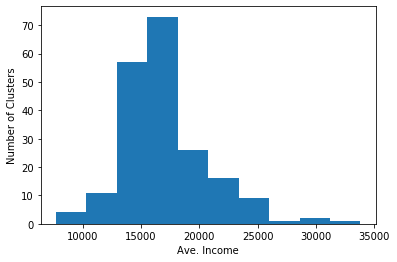

In [17]:
test(testPoints)

In [128]:
import numpy as np 

def graphRemovedErr(points, kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1):
    """
    Should produce graphs of the error in training and holdout point sets, and
    the ratio of the error of the points, after clustering for the given values of k.
    For details see Problem 1.
    """

    # Your Code Here: 
    
    errors_train = []
    errors_test = []
    for kval in kvals:
        train_set, test_set = randomPartition(points, 0.8)
        clusters, maxDist = kmeans(train_set, kval, cutoff, County, minIters = 3, maxIters = 100, toPrint = False)
        summation_train = 0
        summation_test = 0
        for cluster in clusters:
            for point in cluster.getPoints():
                summation_train += (point.distance(cluster.getCentroid()))**2
        errors_train.append(summation_train/len(train_set))
        for point in test_set:
            distances = []
            for cluster in clusters:
                distances.append((point.distance(cluster.getCentroid()))**2)
#             print(distances)
            summation_test += np.asarray(distances).min()
        errors_test.append(summation_test/len(test_set))
    pylab.figure()
    pylab.plot(kvals, errors_train, label = "Train Set")
    pylab.plot(kvals, errors_test, label = "Test Set")
    pylab.xlabel('K-value')
    pylab.ylabel('Squared Sum of Distances')
    pylab.legend()
    pylab.figure()
    pylab.plot(kvals, np.asarray(errors_test)/np.asarray(errors_train))
    pylab.title("Ratio of Test Error to Train Set Error")
    pylab.xlabel('K-value')
    pylab.ylabel('Squared Sum of Distances')
    return errors_train, errors_test

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Total Number of iterations = 5 Max Diameter = 0.35784525120095456
0.0643377861051379
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.3352068890313844
0.046622563097732196
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.2988699026238217
0.05777138148774735
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 0.2432326600929773
0.049814600955036176
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.22725360174408113
0.04453301069088554
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.1532215757054716
0.05262801442293293


([0.02144338215558379,
  0.013642838084286917,
  0.010545141144836765,
  0.00674559841589685,
  0.005455073926863142,
  0.0034073484782434194],
 [0.02123304006292321,
  0.02490281633765299,
  0.01850198263940459,
  0.022650968589953552,
  0.019116846164628665,
  0.01852706531643656])

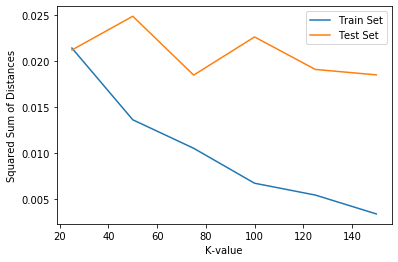

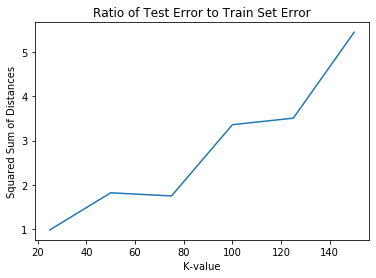

In [129]:
graphRemovedErr(testPoints)

Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 1.6774081036815365
0.058961642134484404
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Total Number of iterations = 7 Max Diameter = 0.8268269090018889
0.030376166607355492
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Total Number of iterations = 5 Max Diameter = 0.6465556247387647
0.03565875661396068
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Total Number of iterations = 8 Max Diameter = 0.8191522305817053
0.05001813572297518
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Total Number of iterations =

([0.028741554729030706,
  0.019661996473060248,
  0.016301329516941077,
  0.014956225970043013,
  0.013221371518619603,
  0.013580184368260749],
 [0.02888276802282275,
  0.020611061145922937,
  0.023158977920989577,
  0.01864984814218442,
  0.015903793540329447,
  0.015469453341530128])

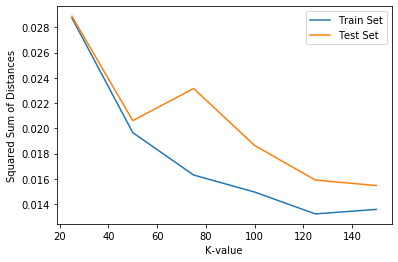

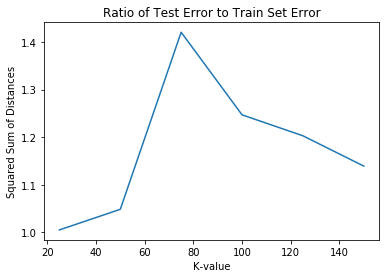

In [130]:
graphRemovedErr(points)

## Problem #2

In [121]:
def home_clustering(points, kval = 50, myHome = 'CASantaClara', cutoff = 0.1):
    home_clusters = []
    for i in range (3):
        clusters = kmeans(points, kval, cutoff, County, minIters = 3, maxIters = 100, toPrint = False)[0]
        for cluster in clusters:
            if cluster.contains(myHome):
                home_clusters.append(cluster)
                continue
    for cluster in home_clusters:
        print ("Home Cluster: ", cluster)
        print("")

In [122]:
home_clustering(points)

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Total Number of iterations = 6 Max Diameter = 0.8289114759331238
0.04769039685308552
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 1.662269749557053
0.07230080422529644
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.9143268702428017
0.06954176475658219
Home Cluster:  CAContraCosta, CAMarin, CASanFrancisco, CASanMateo, CASantaClara, CASantaCruz, COBoulder, COClearCreek, COEagle, COPitkin, CORoutt, COSanMiguel, COSummit, CTFairfield, GAFulton, IDBlaine, ILDuPage, ILLake, KSJohnson, MDHoward, MDMontgomery, MAMiddlesex, MANantucket, MANorfolk, MIOakland, MIWashtenaw, MNHennepin, NJBergen, NJHunterdon, NJMonmouth, NJMorris, NJSomerset, NYNassau, NYNewYork, NYRockland, NYWestchester, PAChester, PAMontgomery, TNWilliamson, UTSummit, VAAlbemarle

## Problem # 3


In [159]:
def getAvePoverty(cluster):
    """
    Given a Cluster object, finds the average poverty field over the members
    of that cluster.
    
    cluster: the Cluster object to check
    
    Returns: a float representing the computed average income value
    """
    tot = 0.0
    numElems = 0
    for c in cluster.getPoints():
        tot += c.getOriginalAttrs()[2]

    return float(tot) / len(cluster.getPoints())

Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.8286158260984906
0.07238221213307058
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Total Number of iterations = 5 Max Diameter = 1.072736573621268
0.035135027878077735
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Total Number of iterations = 5 Max Diameter = 1.1076113478570555
0.06754497448571624
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Total Number of iterations = 5 Max Diameter = 1.1281710067609108
0.04462123806181729
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Total Number of iterations = 7 Max Diameter = 0.5947441729023851
0.043401557997957606
Starting iteration 0
Starting iteration 1
Startin

[23.186260638840523,
 19.365788398792287,
 15.551747831795788,
 17.447029615734955,
 17.761646400404583,
 15.324977383005345]

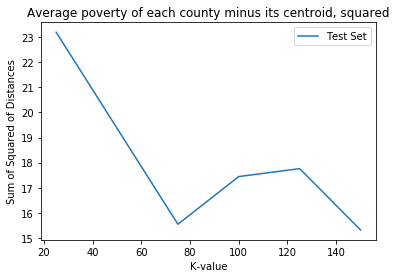

In [170]:
def graphPredictionErr(points, dimension, kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1):
    """
    Given input points and a dimension to predict, should cluster on the
    appropriate values of k and graph the error in the resulting predictions,
    as described in Problem 3.
    """

	# Your Code Here
    County.weights[2] = 0.
    errors_test = []
    for kval in kvals:
        train_set, test_set = randomPartition(points, 0.8)
        clusters, maxDist = kmeans(train_set, kval, cutoff, County, minIters = 3, maxIters = 100, toPrint = False)
        summation_pov_test = 0
        for point in test_set:
            distances = []
            for cluster in clusters:
                distances.append((point.distance(cluster.getCentroid()))**2)
            closest_cluster = clusters[np.asarray(distances).argmin()]
            avg_income = getAvePoverty(closest_cluster)
            pov_error = (avg_income - point.getOriginalAttrs()[2])**2 
            summation_pov_test += pov_error
        errors_test.append(summation_pov_test/len(test_set))
    pylab.figure()
#     pylab.plot(kvals, errors_train, label = "Train Set")
    pylab.plot(kvals, errors_test, label = "Test Set")
    pylab.xlabel('K-value')
    pylab.ylabel('Sum of Squared of Distances')
    pylab.title('Average poverty of each county minus its centroid, squared')
    pylab.legend()
    return errors_test

graphPredictionErr(points, [2], kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1)

(array([ 139., 1021., 1083.,  511.,  189.,   66.,   28.,    7.,    3.,
           2.]),
 array([ 0.  ,  5.69, 11.38, 17.07, 22.76, 28.45, 34.14, 39.83, 45.52,
        51.21, 56.9 ]),
 <a list of 10 Patch objects>)

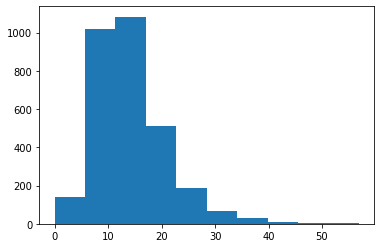

In [169]:
poverties = []
for point in points:
    poverties.append(point.getOriginalAttrs()[2])
pylab.hist(poverties)

Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 1.6449538311261058
0.08729751867326695
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 1.1944905225884033
0.08768496695214302
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Total Number of iterations = 5 Max Diameter = 1.0044773391467208
0.06798287521845657
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 0.5651483170160901
0.08925418083813429
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Total Number of iterations = 4 Max Diameter = 1.1284971295045259
0.09484922432264542
Starting iteration 0
Starting iteration 1
Starting iteration 2
Total Number of iterations = 3 Max Diameter = 0.6999210693041212
0.07687097042690283


[22.928140239327163,
 19.228464016714415,
 16.51805745789924,
 16.1984922158274,
 14.820638056801542,
 14.900796482175844]

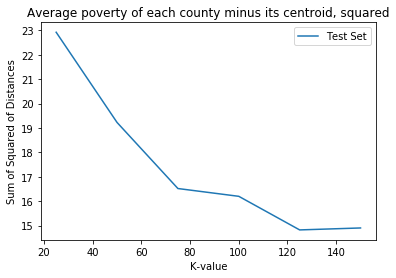

In [179]:
def graphPredictionErr2(points, dimension, kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1):
    """
    Given input points and a dimension to predict, should cluster on the
    appropriate values of k and graph the error in the resulting predictions,
    as described in Problem 3.
    """

	# Your Code Here
    County.weights = pylab.array([1.0] * 14)
    County.weights[2] = 0.
    County.weights[dimention] = 0.
    errors_test = []
    for kval in kvals:
        train_set, test_set = randomPartition(points, 0.8)
        clusters, maxDist = kmeans(train_set, kval, cutoff, County, minIters = 3, maxIters = 100, toPrint = False)
        summation_pov_test = 0
        for point in test_set:
            distances = []
            for cluster in clusters:
                distances.append((point.distance(cluster.getCentroid()))**2)
            closest_cluster = clusters[np.asarray(distances).argmin()]
            avg_income = getAvePoverty(closest_cluster)
            pov_error = (avg_income - point.getOriginalAttrs()[2])**2 
            summation_pov_test += pov_error
        errors_test.append(summation_pov_test/len(test_set))
    pylab.figure()
#     pylab.plot(kvals, errors_train, label = "Train Set")
    pylab.plot(kvals, errors_test, label = "Test Set")
    pylab.xlabel('K-value')
    pylab.ylabel('Sum of Squared of Distances')
    pylab.title('Average poverty of each county minus its centroid, squared')
    pylab.legend()
    return errors_test

graphPredictionErr(points, 7, kvals = [25, 50, 75, 100, 125, 150], cutoff = 0.1)

In [172]:
print(points[0].getOriginalAttrs())

[9.48000e+04 1.85180e+04 1.09000e+01 4.36710e+04 2.80000e+00 1.02000e+01
 1.24940e+04 5.14000e+01 7.87000e+01 1.80000e+01 8.64000e+02 2.86000e+01
 7.32000e+01 1.04785e+05]
